In [1]:
import pandas as pd
df=pd.read_csv("/kaggle/input/flight-price-prediction/Clean_Dataset.csv")
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


Importing needed modules

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


we can clearly see that the data is clean enough and dosent have any null values across the columns thus data doesn't need much of cleaning,so we can remove un wanted datas from the data framee

In [4]:
#removing outliers
df1=df.drop(["Unnamed: 0","flight","departure_time","arrival_time","stops"],axis=1)
df2=df1.copy()
#feature engineering destination and source in on column
df2["source_and_destination"] = df2[["source_city", "destination_city"]].apply(lambda x: "-".join(x), axis=1)
df2.drop(["source_city","destination_city"],axis=1,inplace=True)
#source and destination is made it into a single column

df2.head()

,airline,class,duration,days_left,price,source_and_destination
0,SpiceJet,Economy,2.17,1,5953,Delhi-Mumbai
1,SpiceJet,Economy,2.33,1,5953,Delhi-Mumbai
2,AirAsia,Economy,2.17,1,5956,Delhi-Mumbai
3,Vistara,Economy,2.25,1,5955,Delhi-Mumbai
4,Vistara,Economy,2.33,1,5955,Delhi-Mumbai


In [5]:
#seperating dataframes as business and economy for better analysis
df_economy=df2[df2["class"]=="Economy"]
df_business=df2[df2["class"]=="Business"]
dftemp=df1.reset_index() #temporary dataframe used for counts
#df_economy.head()
#df_business.head()

In [6]:
df2.head()

,airline,class,duration,days_left,price,source_and_destination
0,SpiceJet,Economy,2.17,1,5953,Delhi-Mumbai
1,SpiceJet,Economy,2.33,1,5953,Delhi-Mumbai
2,AirAsia,Economy,2.17,1,5956,Delhi-Mumbai
3,Vistara,Economy,2.25,1,5955,Delhi-Mumbai
4,Vistara,Economy,2.33,1,5955,Delhi-Mumbai


# Machine Learning Prediction Model

In [7]:
#Machine learning prediction model Generation
#by analysing the data based on the duration we can observe that it didn't clearly influenced in the price in a stable way so we can remove it
df3=df2.drop('duration',axis=1)

#converting the categorical variables into numeric variables

label_encoder=LabelEncoder()

#converting categorical values of airline
df3['airline']=label_encoder.fit_transform(df2['airline'])
#label maping the transformed data
label_map_airline= dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

#converting categorical values of class
df3['class']=label_encoder.fit_transform(df2['class'])
label_map_class= dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

#converting categorical values of sorce and destination
df3['source_and_destination']=label_encoder.fit_transform(df2['source_and_destination'])
label_map_sd= dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [8]:
x=df3.drop('price',axis=1)
y=df3.price
#x
#y

In [9]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=10)

**Finding best model for prediction**

In [10]:
def best_model(x,y):
    algorithms = {
        'linear_regression' : {
            'model':LinearRegression(),
            'parameters': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model':Lasso(),
            'parameters': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'parameters': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algorithms.items():
        gs =  GridSearchCV(config['model'], config['parameters'], cv=cv, return_train_score=False)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_parameters': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_parameters'])
#by analysing the model using different algorithms i concluded that decision tree could be the best choice
#linear_regression-89.1371%
#lasso-89.1372%
#decision_tree-91.8248%
#their for decision tree is selected for modelling


In [11]:
best_model(x,y)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pi

,model,best_score,best_parameters
0,linear_regression,0.891371,{'normalize': True}
1,lasso,0.891372,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.918248,"{'criterion': 'mse', 'splitter': 'best'}"


*we can clearly see that decision tree is the best moodel with best score of 91.82% hence DecisionTreeRegressor is used for modelling * 

In [12]:
model=DecisionTreeRegressor(criterion='friedman_mse',splitter='best')
model.fit(x_train,y_train)

DecisionTreeRegressor(criterion='friedman_mse')

In [13]:
model.score(x_test,y_test)
#accuracy=91.765

0.9176489868855708

* **Accuracy obtained from modelling is-91.765%**

**Their is a need for this data to be acessible by others def a function so that others can use it**

In [14]:
#defining function to predict price by applying categorical values
#airline=input(str("enter the airline like- SpiceJet/ AirAsia/ Vistara/ GO_FIRST/ Indigo/ Air_India:"))
#Class=input(str("enter the class-Economy/Business:"))
#days_left=int(input("enter no of days left:"))
#routes=input(str("enter the source and destination like Delhi-Mumbai:"))
def predict_price(airline,Class,days_left,routes):
    a=label_map_airline[airline]
    c=label_map_class[Class]
    r=label_map_sd[routes]
    return(model.predict([[a,c,days_left,r]]))
#predict_price(airline,Class,days_left,routes)

remove the # so that the function can take input and work

# Flight Data Analysis

# Analysis by Travel Locations per Airline (Business Class)

Business Class


Air_India


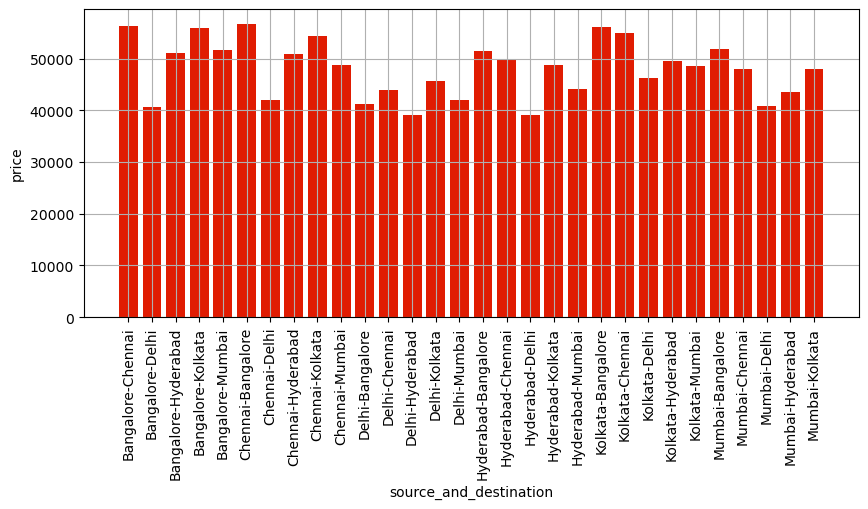

Vistara


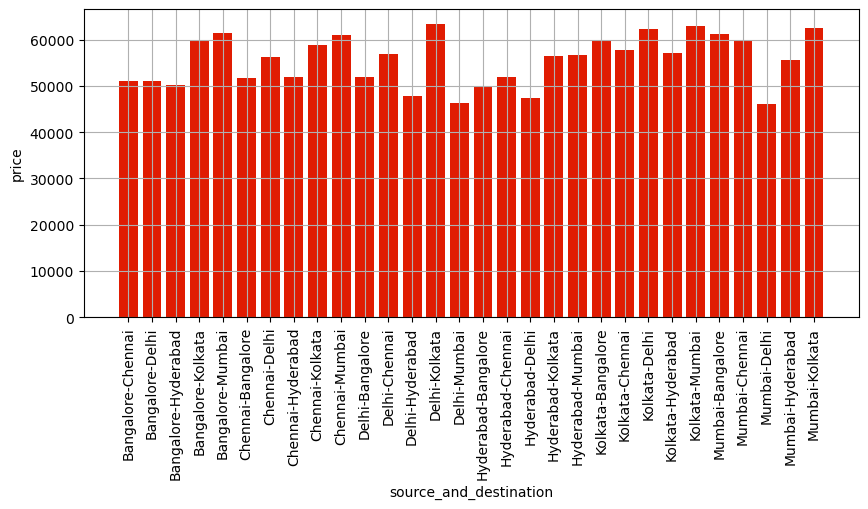

In [15]:
#business class
analysis_businessclass = df_business.groupby("airline")
print("Business Class")
print("\n")
for airline, dfx in analysis_businessclass:
    sd = [source_and_destination for source_and_destination, df in dfx.groupby('source_and_destination')]
    print(airline)
    price_per_sd = dfx.groupby("source_and_destination").mean()['price']
    plt.figure(figsize=(10,4))     
    plt.bar(sd, price_per_sd,color='#e01c02')
    plt.xticks(sd, rotation="vertical")
    plt.grid()
    plt.xlabel("source_and_destination")
    plt.ylabel('price')
    plt.show()

# Analysis by Travel Locations per Airline (Economy Class)

Economy Class


AirAsia


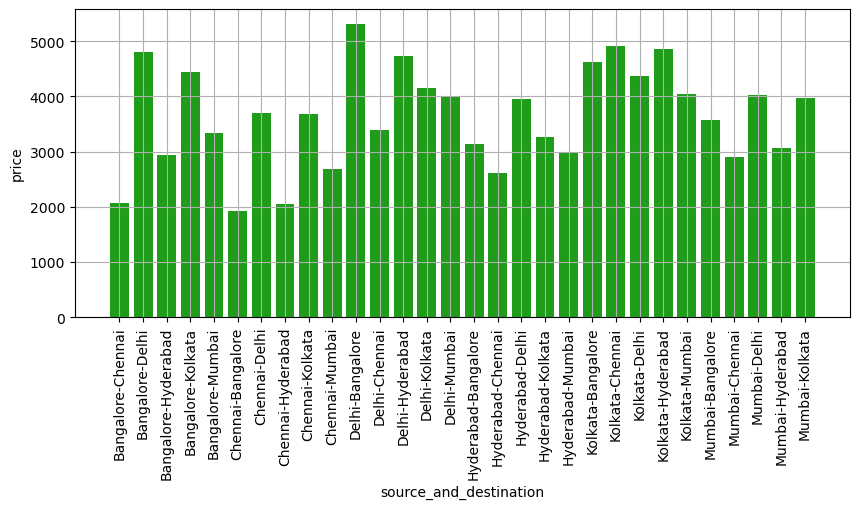

Air_India


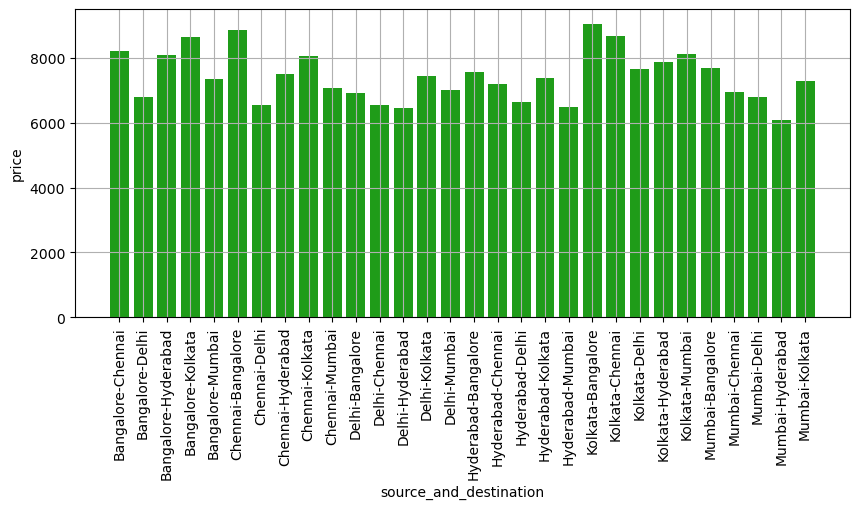

GO_FIRST


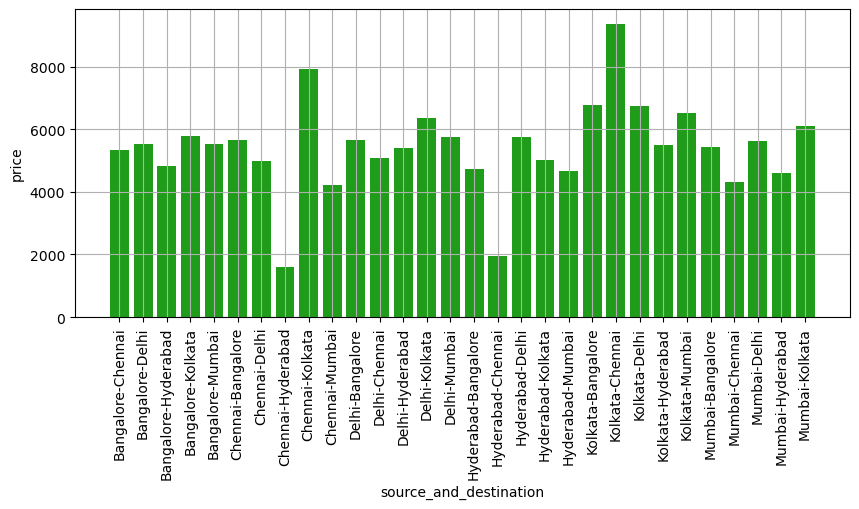

Indigo


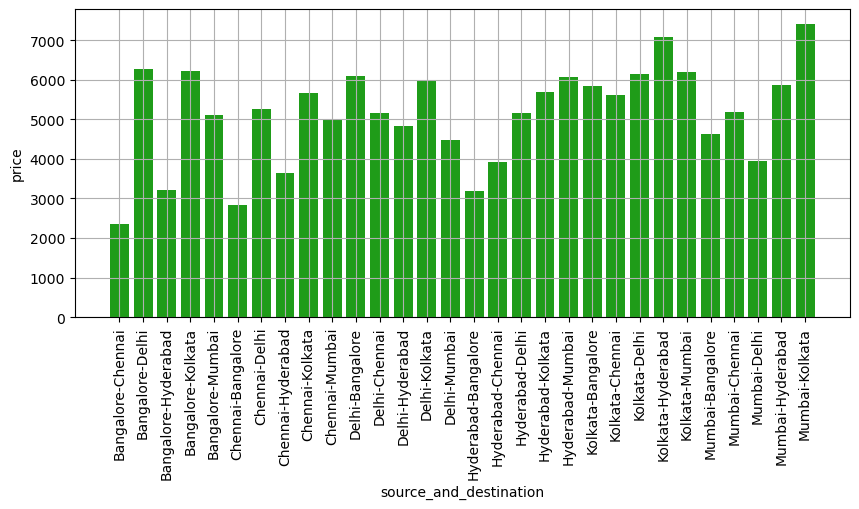

SpiceJet


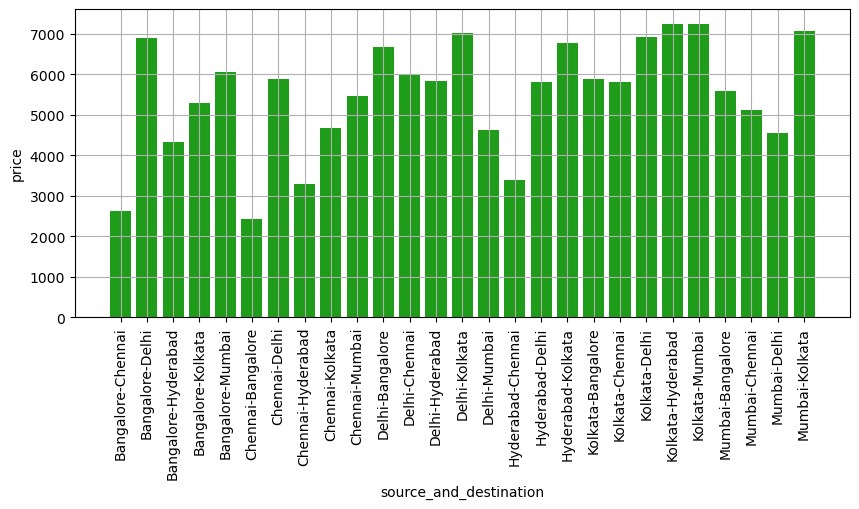

Vistara


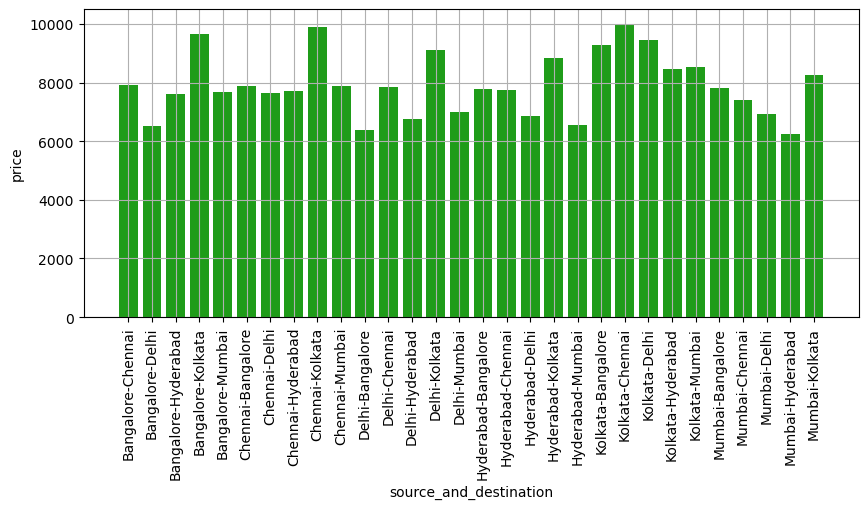

In [16]:
#economy class
analysis_economyclass = df_economy.groupby("airline")
print("Economy Class")
print("\n")
for airline, dfx in analysis_economyclass:
    sd = [source_and_destination for source_and_destination, df in dfx.groupby('source_and_destination')]
    print(airline)
    price_per_sd = dfx.groupby("source_and_destination").mean()['price']
    plt.figure(figsize=(10,4))     
    plt.bar(sd, price_per_sd,color='#1f9c19')
    plt.xticks(sd, rotation="vertical")
    plt.grid()
    plt.xlabel("source_and_destination")
    plt.ylabel('price')
    plt.show()

# Analysing the busiest destination

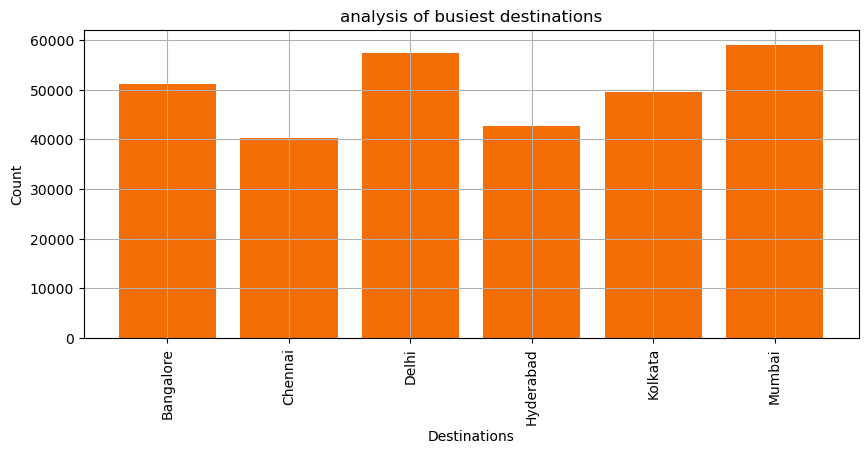

In [17]:
destination_analysis=dftemp.groupby("destination_city").count()['index']
destinations=[destination_city for destination_city,df in df1.groupby("destination_city") ]
plt.figure(figsize=(10,4))     
plt.bar(destinations, destination_analysis,color='#f56d05')
plt.xticks(destinations, rotation="vertical")
plt.grid()
plt.title("analysis of busiest destinations")
plt.xlabel("Destinations")
plt.ylabel('Count')
plt.show()

# Analysing the busiest source cities

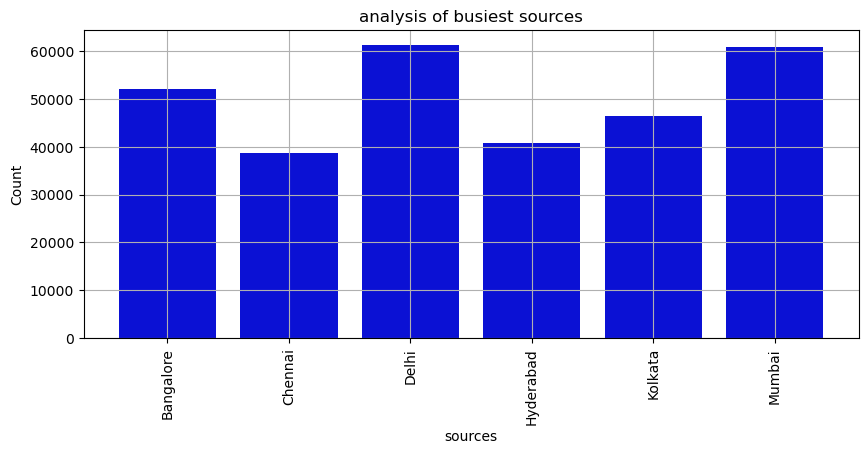

In [18]:
source_analysis=dftemp.groupby("source_city").count()['index']
sources=[source_city for source_city,df in df1.groupby("source_city") ]
plt.figure(figsize=(10,4))     
plt.bar(sources, source_analysis,color='#0b11d4')
plt.xticks(sources, rotation="vertical")
plt.grid()
plt.title("analysis of busiest sources")
plt.xlabel("sources")
plt.ylabel('Count')
plt.show()

# Analysing the busiest routes

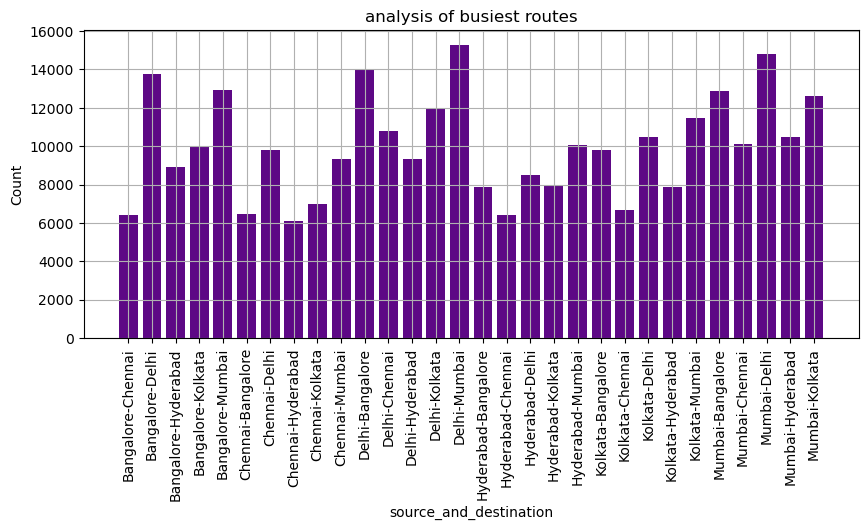

In [19]:
dftemp2=df2.reset_index()
routes_analysis=dftemp2.groupby("source_and_destination").count()['index']
routes=[source_and_destination for source_and_destination,df in dftemp2.groupby("source_and_destination") ]
plt.figure(figsize=(10,4))     
plt.bar(routes, routes_analysis,color="#5d0885")
plt.xticks(routes, rotation="vertical")
plt.grid()
plt.title("analysis of busiest routes")
plt.xlabel("source_and_destination")
plt.ylabel('Count')
plt.show()

# Analysing the shares of airlines in total domestic air travel

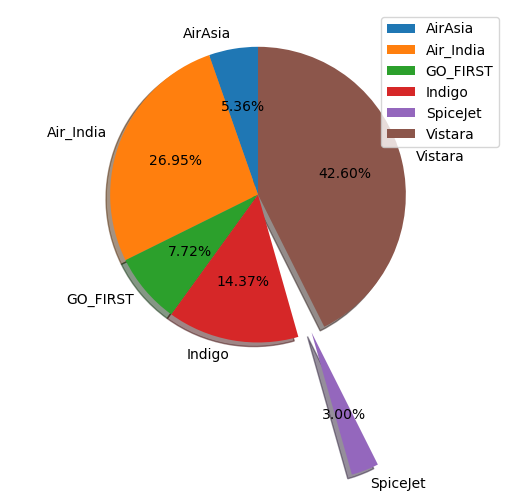

In [20]:
airlines = [airline for airline, df in df2.groupby('airline')]
shares=dftemp2.groupby("airline").count()['index']
plt.axis('equal')
plt.pie(shares,labels=airlines,shadow=True, autopct='%0.2f%%',radius=1,startangle=90,explode=[0,0,0,0,1,0])
plt.legend(loc='best')
plt.show()     

# Analysing the effect of day left on price

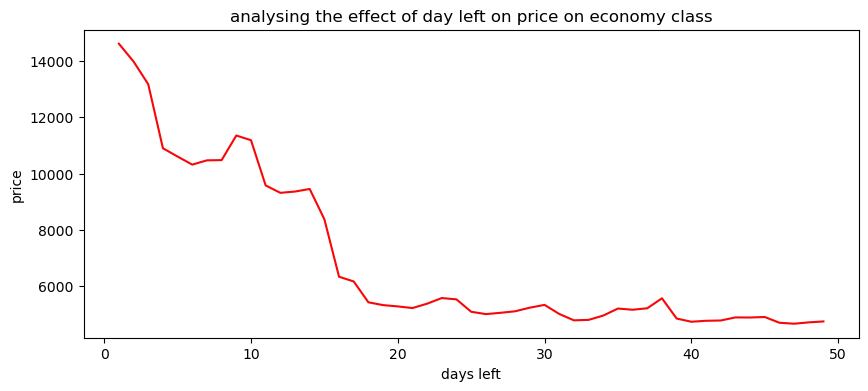

In [21]:
#economy class
day_analysis=df_economy.groupby("days_left").mean()['price']
day=[days_left for days_left,df in df_economy.groupby("days_left") ]
plt.figure(figsize=(10,4))     
plt.plot(day, day_analysis,color='#f70707')
plt.title("analysing the effect of day left on price on economy class")
plt.xlabel("days left")
plt.ylabel('price')
plt.show()

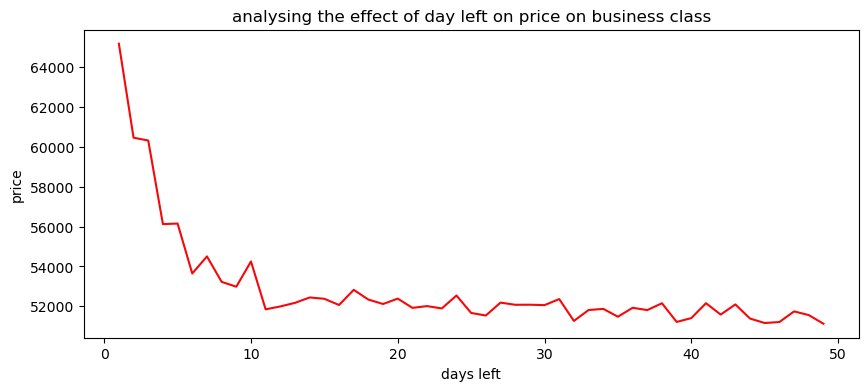

In [22]:
#business class
day_analysis_b=df_business.groupby("days_left").mean()['price']
day_b=[days_left for days_left,df in df_business.groupby("days_left") ]
plt.figure(figsize=(10,4))     
plt.plot(day_b, day_analysis_b,color='#f70707')
plt.title("analysing the effect of day left on price on business class")
plt.xlabel("days left")
plt.ylabel('price')
plt.show()

# Analysing the density of travellers in each class

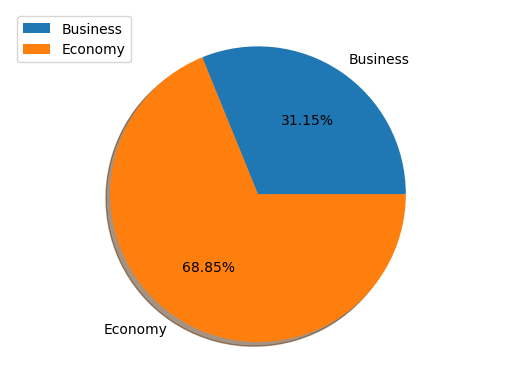

In [23]:
dftemp3=dftemp.copy()
dftemp3["Class"]=dftemp3['class']
dftemp3.drop('class',axis=1,inplace=True)
travelclass=[Class for Class,df in dftemp3.groupby("Class")]
density=dftemp3.groupby('Class').count()['index']
plt.axis('equal')
plt.pie(density,labels=travelclass,shadow=True,autopct="%0.2f%%",radius=1)
plt.legend(loc='best')